<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻🚙 Dev

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/pic1_rect.png", width=400px>
  <figcaption>The view from a Duckiebot when centered in its lane.</figcaption>
  </div>
</figure>

In [1]:
!pip3 --version
!pip3 install matplotlib opencv-python

pip 22.3.1 from /home/guimauve/.local/lib/python3.10/site-packages/pip (python 3.10)
Defaulting to user installation because normal site-packages is not writeable


In [2]:
## Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Let's load the image as well as the homography for the corresponding camera into Python.

In [3]:
# Load in the image and generate hsv and grayscale versions
imgbgr = cv2.imread('../images/visual_control/pic1_rect.png')

# OpenCV uses BGR by default, whereas matplotlib uses RGB, so we generate an RGB version for the sake of visualization
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for any color-based filtering
imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

# Most of our operations will be performed on the grayscale version
img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

# The image-to-ground homography associated with this image
H = np.array([-4.137917960301845e-05, -0.00011445854191468058, -0.1595567007347241, 
              0.0008382870319844166, -4.141689222457687e-05, -0.2518201638170328, 
              -0.00023561657746150284, -0.005370140574116084, 0.9999999999999999])

H = np.reshape(H,(3, 3))
Hinv = np.linalg.inv(H)

print(Hinv)

[[-1.60814783e+03  1.12073254e+03  2.56322894e+01]
 [-8.98794107e+02 -9.11232359e+01 -1.66355291e+02]
 [-5.20555699e+00 -2.25281421e-01  1.12688097e-01]]


## Finding the Horizon

[168.]


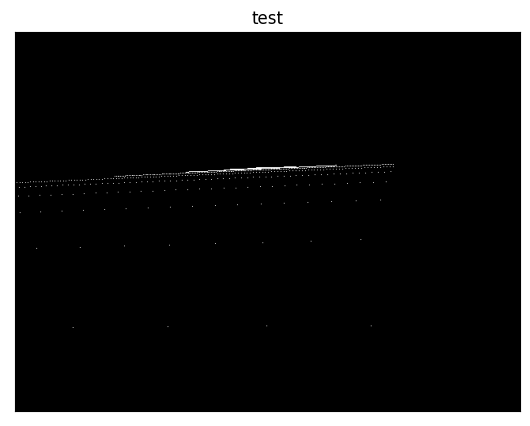

In [33]:
w, h = img.shape
threshold = float("inf")
new_img = np.zeros((w, h))

for i in [.2, .4, .8, 1.5, 3, 6, 12, 24, 50, 200]:
    for j in arange(-10, 10, 0.1):
        x = np.array([[i, j, 1]]).transpose()
        xprime = Hinv.dot(x)
        xprime = xprime/xprime[2]
        if xprime[0] >= w or 0 > xprime[1] >= h or xprime[0] < 0 or xprime[1] < 0:
            continue
        else:
            new_img[int(xprime[1]), int(xprime[0])] = 1
            if xprime[1] < threshold:
                threshold = xprime[1] // 1
print(threshold)
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(new_img,cmap = 'gray')
ax1.set_title('test'), ax1.set_xticks([]), ax1.set_yticks([]);

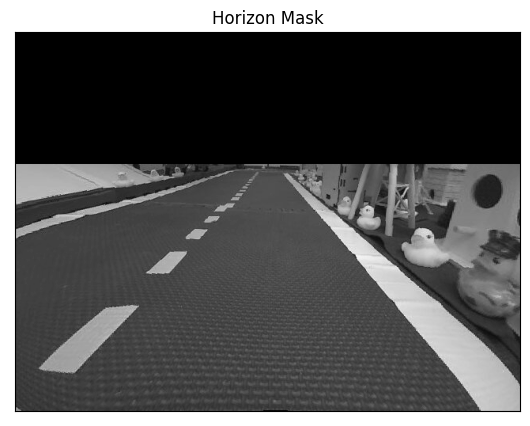

In [34]:
# TODO: Use the homography (technically Hinv) to mask out the horizon
# When generating masks that will be used with OpenCV try and
# instantiate them with dtype=np.uint8
mask_ground = np.ones(img.shape, dtype=np.uint8) # TODO: CHANGE ME
mask_ground[:int(threshold), :] = 0

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img*mask_ground,cmap = 'gray')
ax1.set_title('Horizon Mask'), ax1.set_xticks([]), ax1.set_yticks([]);

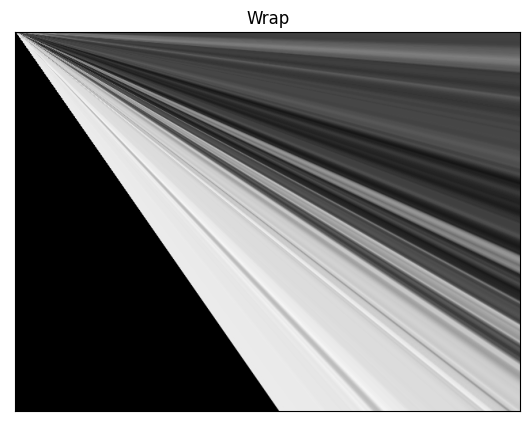

In [39]:
# img1_warp = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
# fig = plt.figure(figsize = (30,20))
# ax1 = fig.add_subplot(1,4,1)
# ax1.imshow(img1_warp, cmap = 'gray')
# ax1.set_title('Wrap'), ax1.set_xticks([]), ax1.set_yticks([]);

## Image perspective

[[ 2.76020546e+00 -2.53760825e+00 -4.93275428e+02]
 [-1.83365867e-15 -4.58387448e+00  7.79258662e+02]
 [ 5.80062577e-05 -7.73343499e-03  1.00000000e+00]]


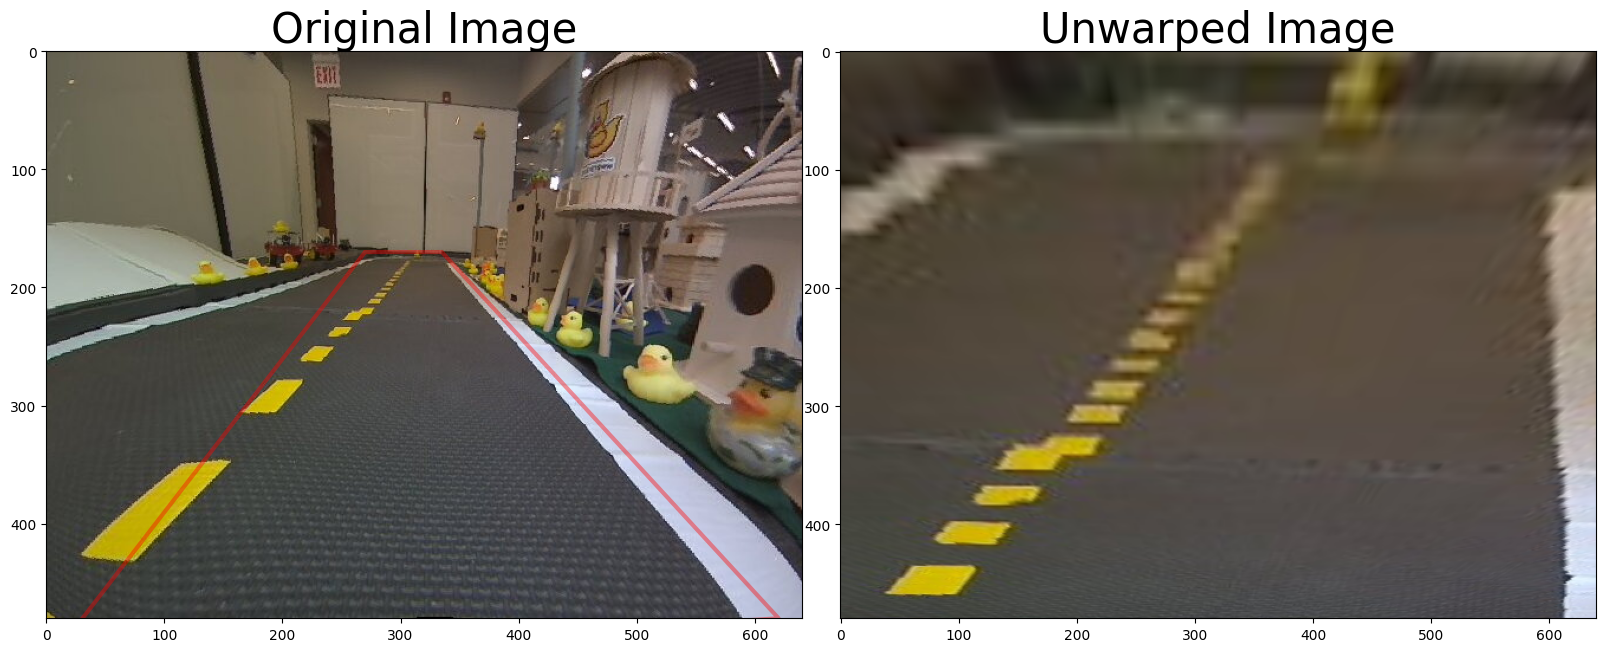

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def unwarp(img, src, dst, testing, M=None):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    if M is None:
        M = cv2.getPerspectiveTransform(src, dst)
    print(M)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if testing:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        f.subplots_adjust(hspace=.2, wspace=.05)
        ax1.imshow(img)
        x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
        y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
        ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
        ax1.set_ylim([h, 0])
        ax1.set_xlim([0, w])
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(cv2.flip(warped, 1))
        ax2.set_title('Unwarped Image', fontsize=30)
        plt.show()
    else:
        return warped, M


im = imgrgb
w, h = im.shape[0], im.shape[1]
# We will first manually select the source points 
# we will select the destination point which will map the source points in
# original image to destination points in unwarped image
src = np.float32([(270,     170),
                  (335,  170),
                  (0,    520),
                  (620,  480)])

dst = np.float32([(600, 0),
                  (0, 0),
                  (600, 531),
                  (0, 531)])

unwarp(im, src, dst, True)

[[-3.61497188e+00  0.00000000e+00  2.24128257e+03]
 [ 0.00000000e+00  6.19854709e+00 -1.23970942e+03]
 [-4.13730687e-04  5.26052104e-03  1.00000000e+00]]


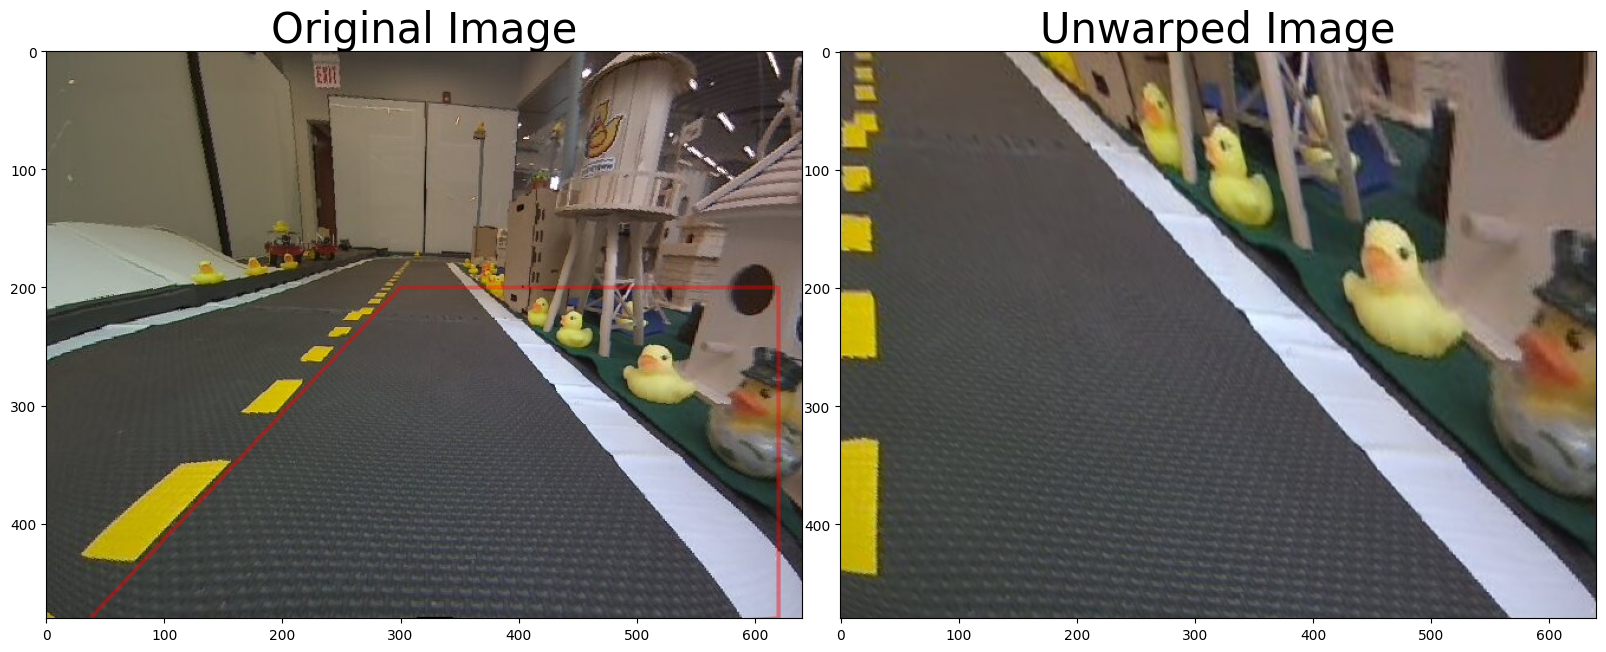

[[-3.61497188e+00  0.00000000e+00  2.24128257e+03]
 [ 0.00000000e+00  6.19854709e+00 -1.23970942e+03]
 [-4.13730687e-04  5.26052104e-03  1.00000000e+00]]


In [41]:
im = imgrgb
w, h = im.shape[0], im.shape[1]
# We will first manually select the source points 
# we will select the destination point which will map the source points in
# original image to destination points in unwarped image
src = np.float32([(300,     200),
                  (620,  200),
                  (0,    520),
                  (620,  480)])

dst = np.float32([(600, 0),
                  (0, 0),
                  (600, 531),
                  (0, 531)])

unwarp(im, src, dst, True)
test_imgrbg, _ = unwarp(im, src, dst, False)

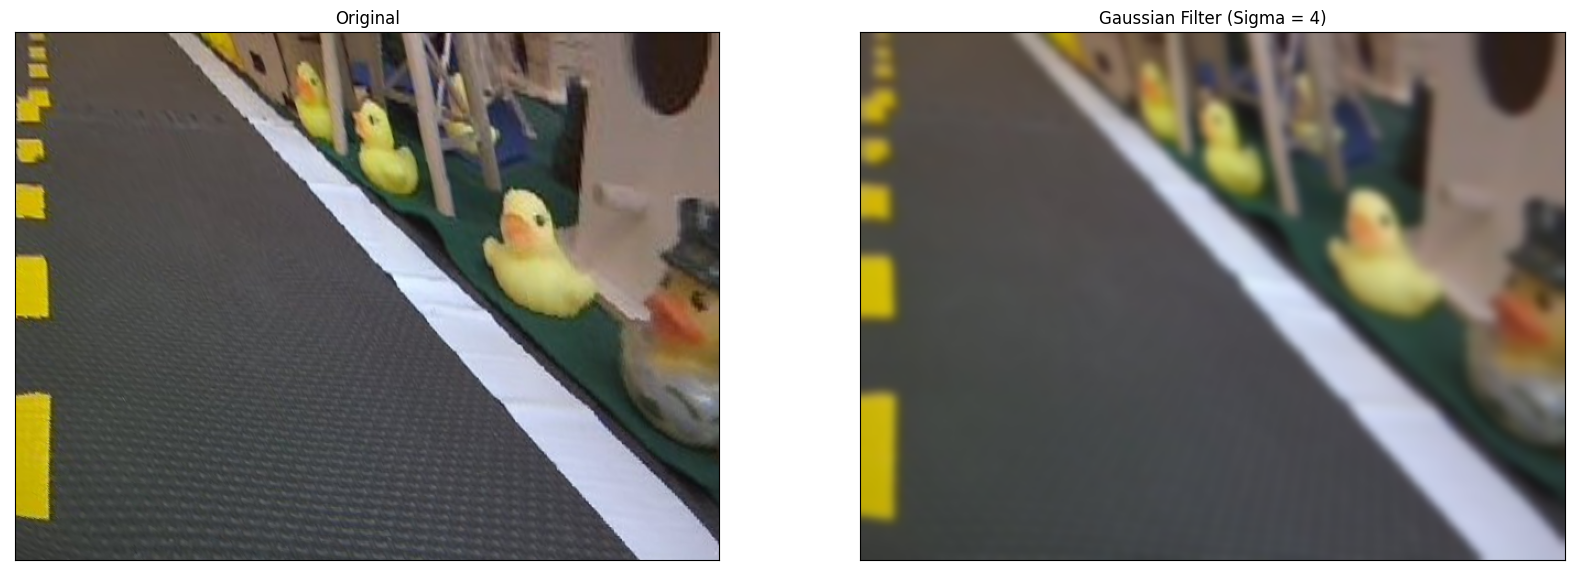

In [42]:
# TODO: Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 4 # CHANGE ME
img = cv2.flip(test_imgrbg, 1)
# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);

[[-3.61497188e+00  0.00000000e+00  2.24128257e+03]
 [ 0.00000000e+00  6.19854709e+00 -1.23970942e+03]
 [-4.13730687e-04  5.26052104e-03  1.00000000e+00]]
[[-3.61497188e+00  0.00000000e+00  2.24128257e+03]
 [ 0.00000000e+00  6.19854709e+00 -1.23970942e+03]
 [-4.13730687e-04  5.26052104e-03  1.00000000e+00]]


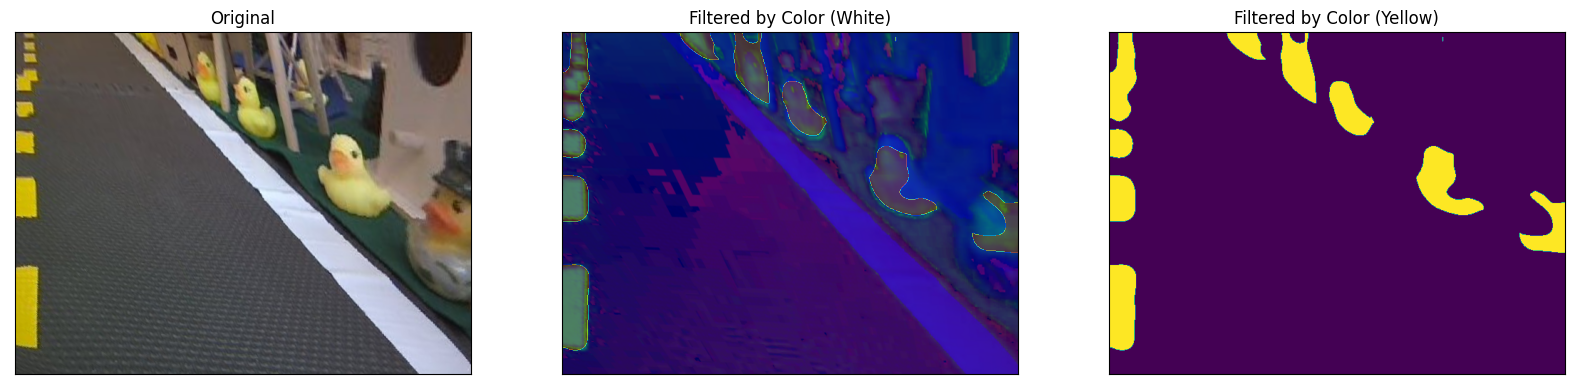

In [45]:
im = imghsv
w, h = im.shape[0], im.shape[1]
# We will first manually select the source points 
# we will select the destination point which will map the source points in
# original image to destination points in unwarped image
src = np.float32([(300,     200),
                  (620,  200),
                  (0,    520),
                  (620,  480)])

dst = np.float32([(600, 0),
                  (0, 0),
                  (600, 531),
                  (0, 531)])

test_imghsv, _ = unwarp(im, src, dst, False)
test_imgrbg, _ = unwarp(imgrgb, src, dst, False)

img = cv2.flip(test_imghsv, 1)
# Smooth the image using a Gaussian kernel
sigma = 8
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

# Using the above tool, we can identify the bounds as follows
#       These values represent the maximum range, so they don't filter out anything
yellow_lower_hsv = np.array([15, 100, 100])
yellow_upper_hsv = np.array([40, 255, 255]) 

mask_yellow = cv2.inRange(img_gaussian_filter, yellow_lower_hsv, yellow_upper_hsv)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(cv2.flip(test_imgrbg, 1))
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img)
ax2.imshow(mask_yellow, cmap='jet', alpha=0.5)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img)
ax3.imshow(mask_yellow)
ax3.set_title('Filtered by Color (Yellow)'), ax3.set_xticks([]), ax3.set_yticks([]);

(Text(0.5, 1.0, 'Detection'), [], [])

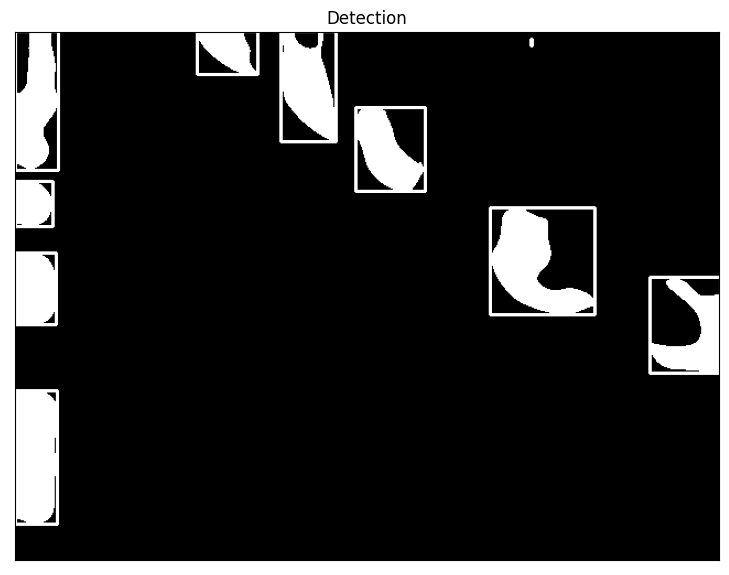

In [46]:
img = mask_yellow
ret,thresh = cv2.threshold(img,127,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,10,10),2)


fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Detection'), ax1.set_xticks([]), ax1.set_yticks([])

## let try to remove the line

## Gaussian Blurring

In [52]:
img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

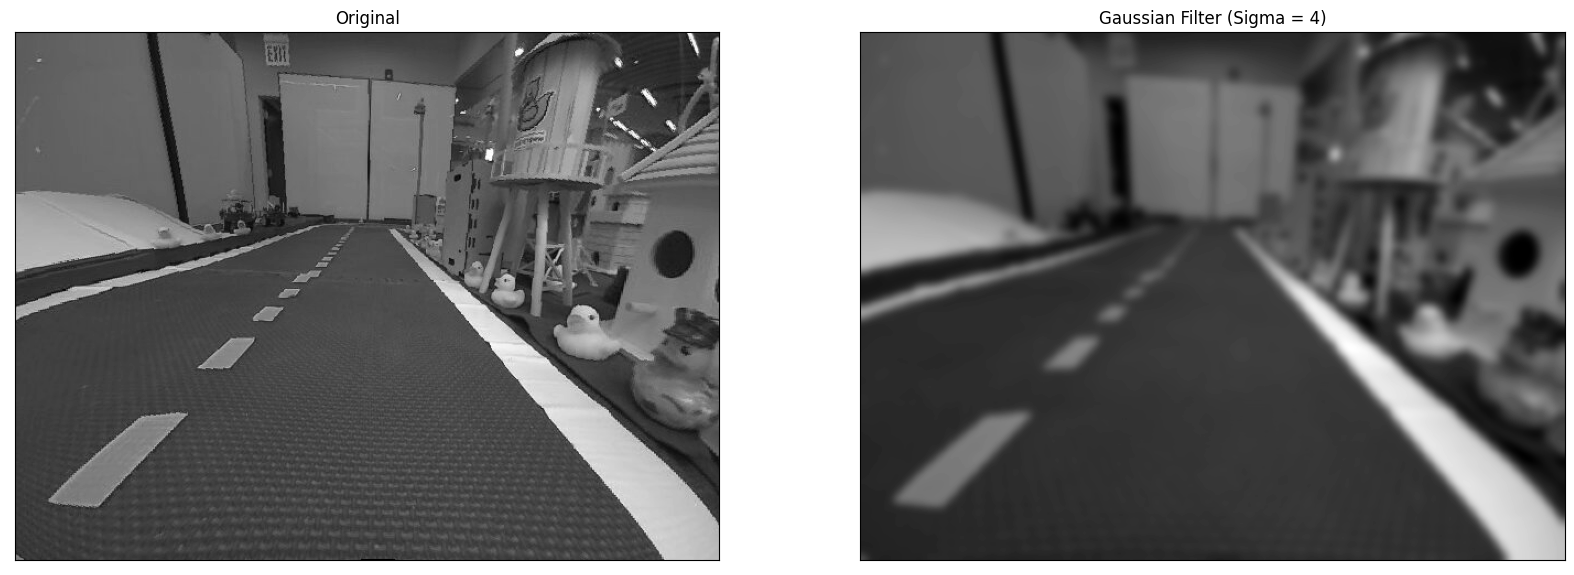

In [53]:
# TODO: Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 4 # CHANGE ME

img = cv2.cvtColor(imgrgb, cv2.COLOR_BGR2GRAY)

# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);

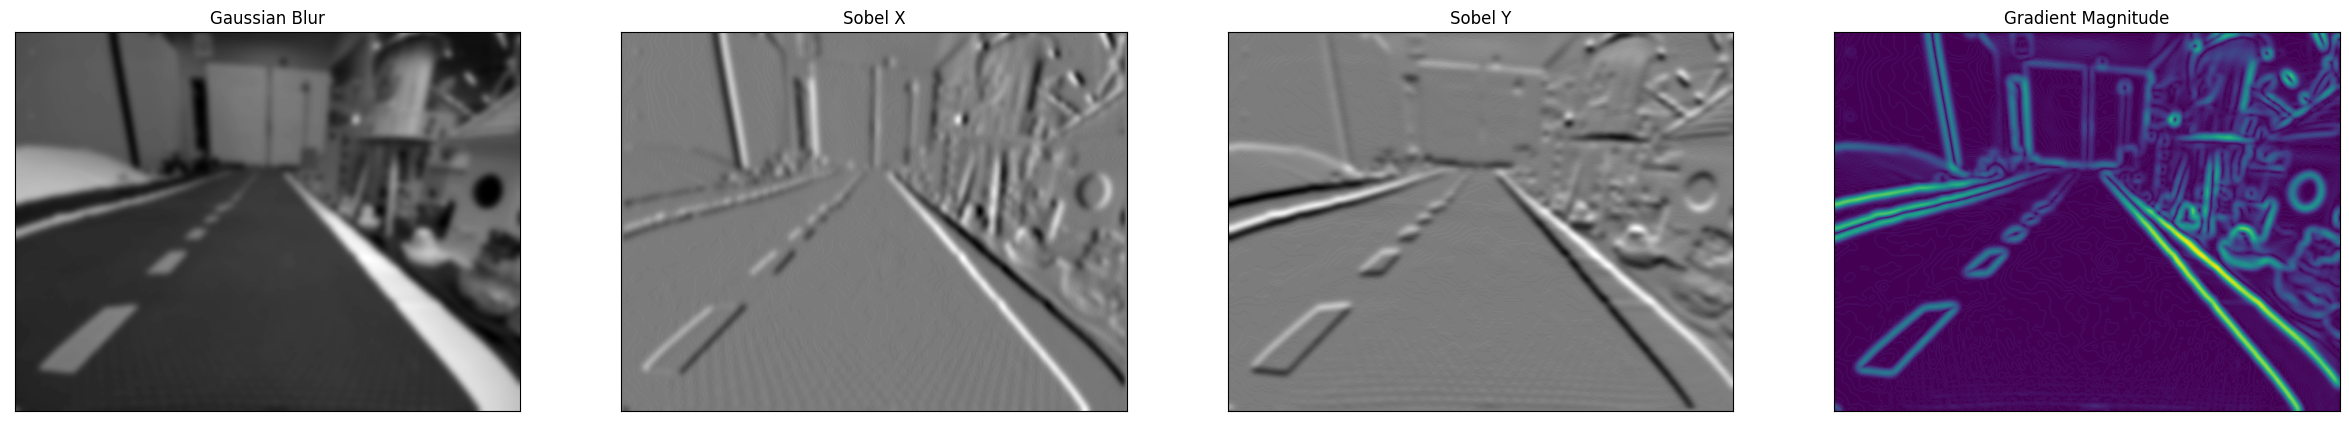

In [54]:
# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)

# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Compute the orientation of the gradients
Gdir = cv2.phase(np.array(sobelx, np.float32), np.array(sobely, dtype=np.float32), angleInDegrees=True)

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.uint8(Gmag))
ax4.set_title('Gradient Magnitude'), ax4.set_xticks([]), ax4.set_yticks([]);

## A Varient of Non-maximal Supression

With a suitable choice for the standard deviation, we have smoothed out some of the noise and texture in the image (e.g., the road), reducing the number of candidate edges while preserving most of the edges that corresopnd to lane markings.

Under the assumption that the edges associated with lane markings are stronger than most of the edges in the image (in terms of the magnitude of the gradients), we can further eliminate distractors by only keeping edges whose gradient magnitude is greater than a threshold. 

### Example: A form of non-maximal supression

In this exercise, we will take a look at the histogram over gradient magnitudes to better understand the distribution of gradient magnitudes. Based on the histogram, we can choose a magnitude threshold that we will use to filter out weaker edges.

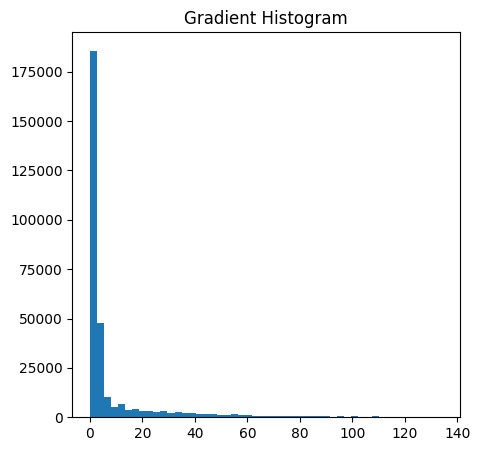

In [55]:
# Visualize the histogram over gradient magnitudes
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist((Gmag*mask_ground).flatten(), bins=50)
ax1.set_title('Gradient Histogram');

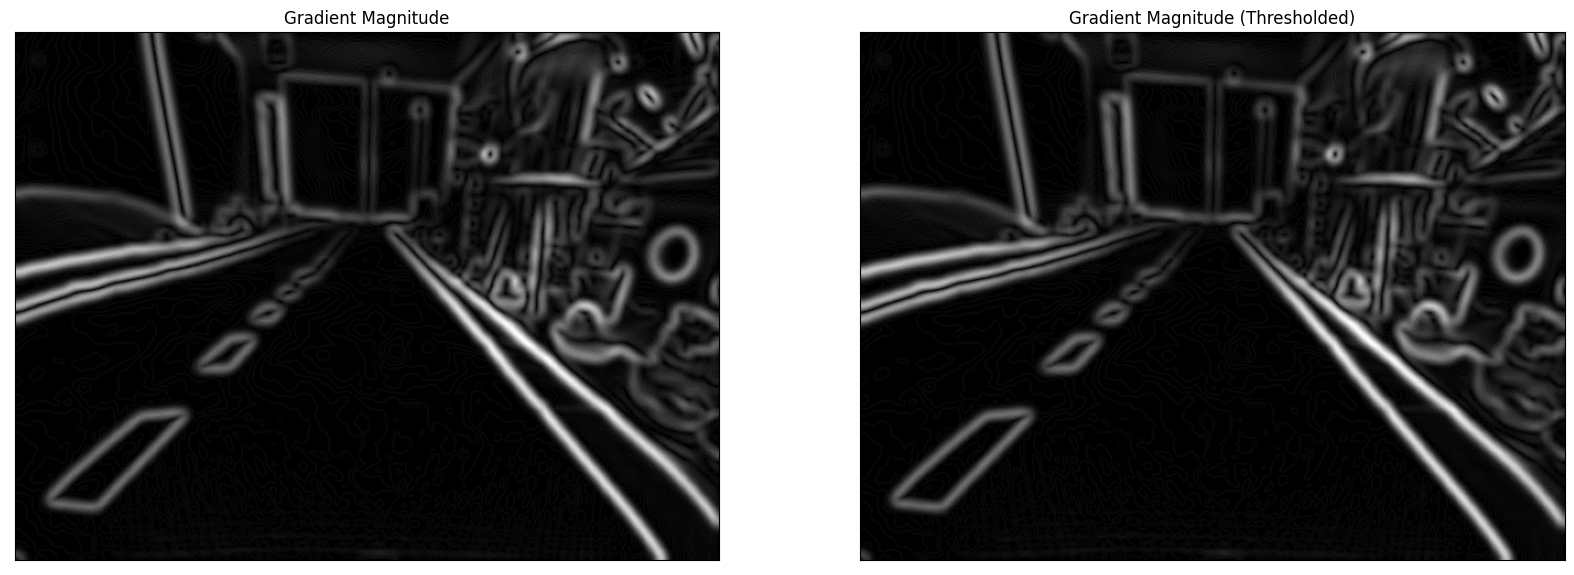

In [56]:
# TODO: Use the histogram above to choose the minimum threshold on the gradient magnitude. 
#       Edges whos gradient magnitude is below this threshold will be filtered out.
threshold = np.random.rand(1,1) # CHANGE ME

mask_mag = (Gmag > threshold)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Gmag, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Thresholded)'), ax2.set_xticks([]), ax2.set_yticks([]);

## Color-based Masking

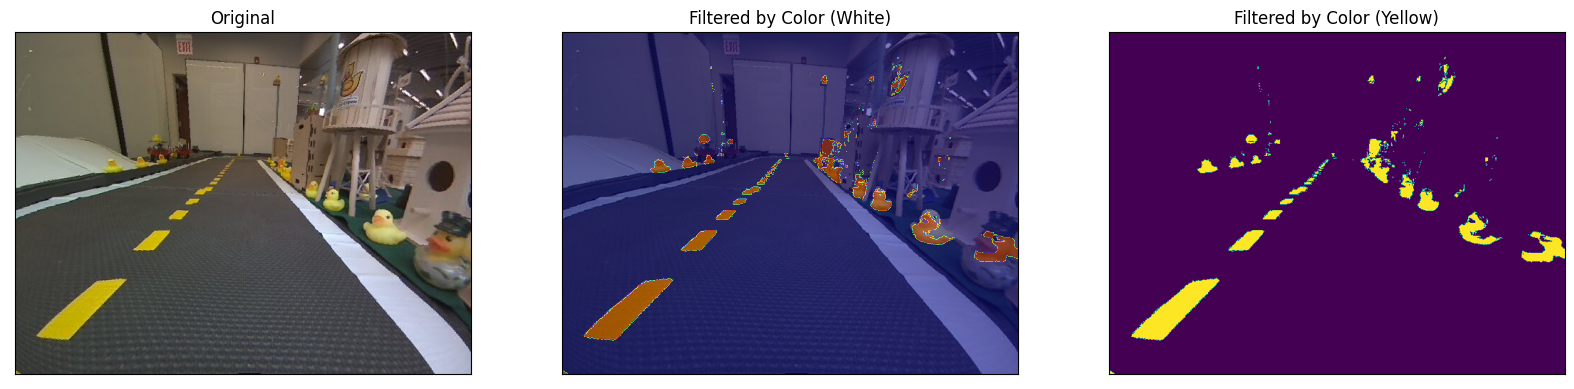

In [57]:
# Using the above tool, we can identify the bounds as follows
#       These values represent the maximum range, so they don't filter out anything
yellow_lower_hsv = np.array([15, 100, 100])
yellow_upper_hsv = np.array([40, 255, 255]) 

mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(imgrgb)
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_yellow, cmap='jet', alpha=0.5)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(imgrgb)
ax3.imshow(mask_yellow)
ax3.set_title('Filtered by Color (Yellow)'), ax3.set_xticks([]), ax3.set_yticks([]);

## Edge-based Masking

In [58]:
# Let's create masks for the left- and right-halves of the image
width = img.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,int(np.floor(width/2)):width + 1] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,0:int(np.floor(width/2))] = 0

In [59]:
# In the left-half image, we are interested in the right-half of the dashed yellow line, which corresponds to negative x- and y-derivatives
# In the right-half image, we are interested in the left-half of the solid white line, which correspons to a positive x-derivative and a negative y-derivative
# Generate a mask that identifies pixels based on the sign of their x-derivative
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)
mask_sobely_pos = (sobely > 0)
mask_sobely_neg = (sobely < 0)

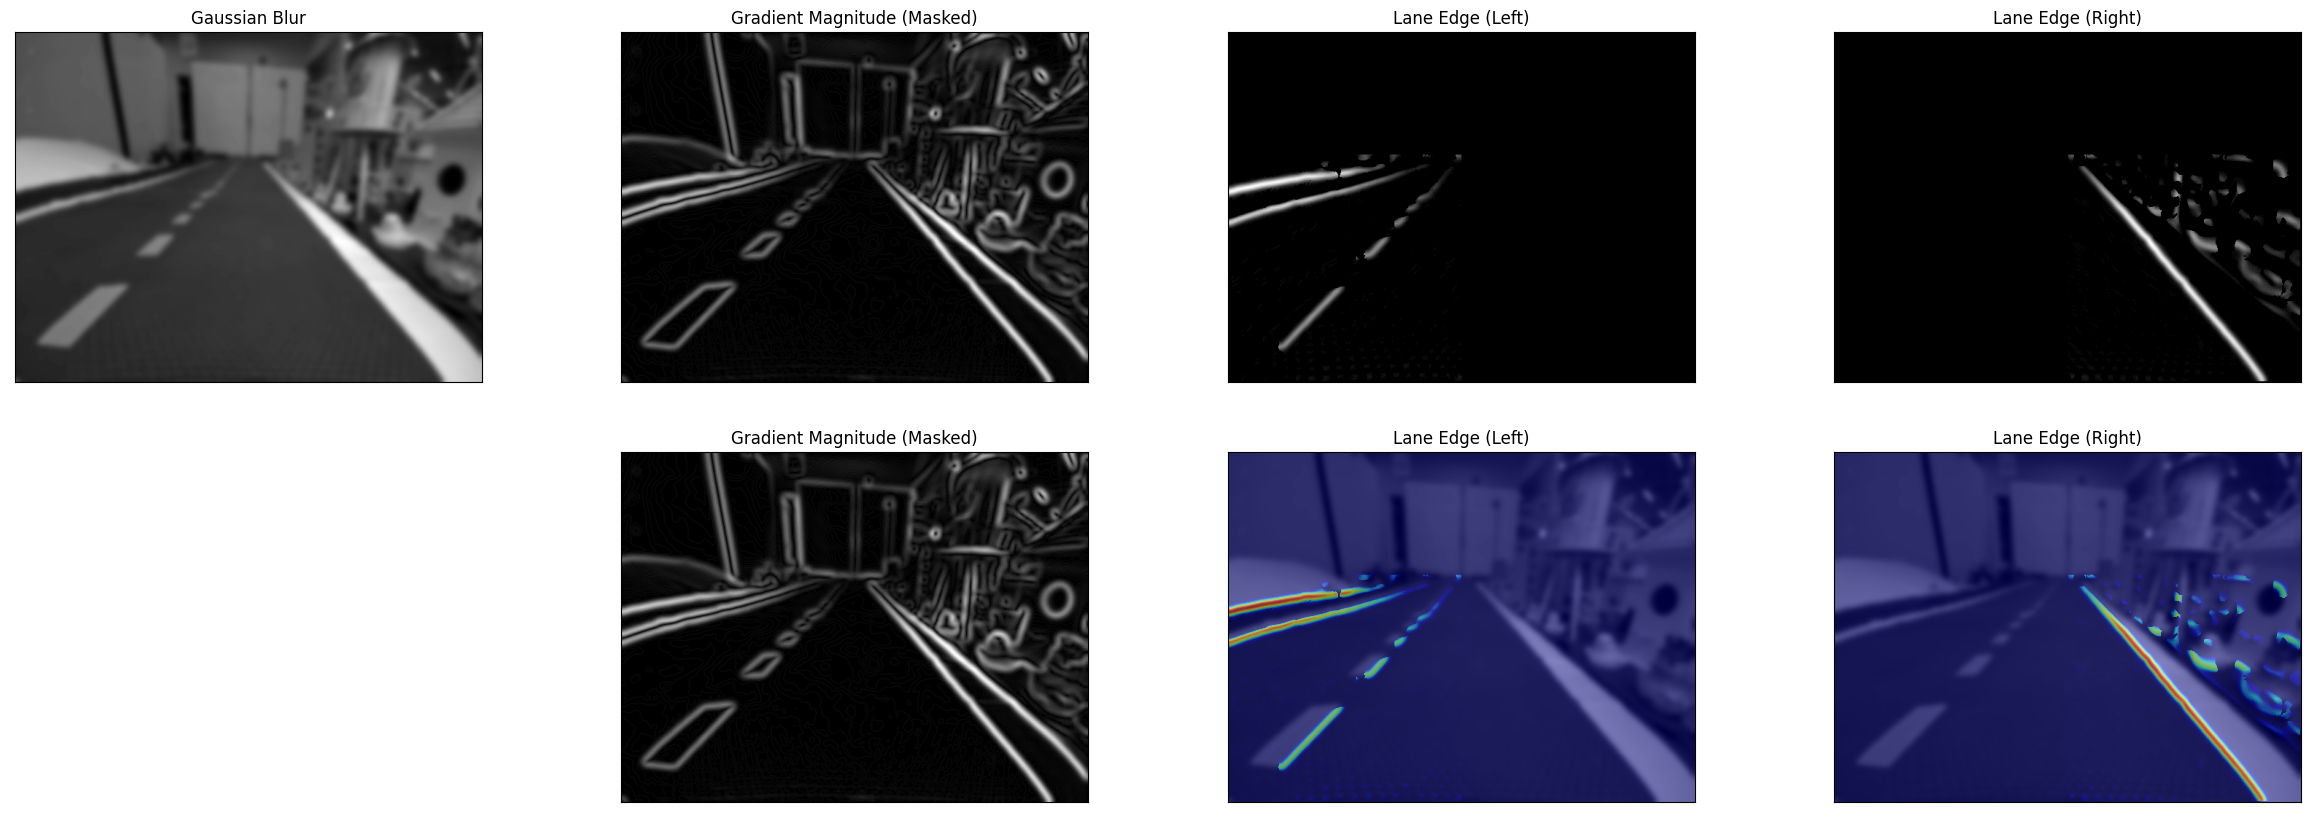

In [60]:
# Let's combine these masks with the gradient magnitude mask
mask_left_edge = mask_ground * mask_left * mask_mag * mask_sobelx_neg * mask_sobely_neg
mask_right_edge = mask_ground * mask_right * mask_mag * mask_sobelx_pos * mask_sobely_neg

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

ax6 = fig.add_subplot(2,4,6)
ax6.imshow(mask_mag*Gmag,cmap = 'gray')
ax6.set_title('Gradient Magnitude (Masked)'), ax6.set_xticks([]), ax6.set_yticks([])
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(img_gaussian_filter,cmap = 'gray')
ax7.imshow(Gmag * mask_left_edge, cmap='jet', alpha=0.5)
ax7.set_title('Lane Edge (Left)'), ax7.set_xticks([]), ax7.set_yticks([])
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(img_gaussian_filter,cmap = 'gray')
ax8.imshow(Gmag * mask_right_edge, cmap='jet', alpha=0.5)
ax8.set_title('Lane Edge (Right)'), ax8.set_xticks([]), ax8.set_yticks([]);

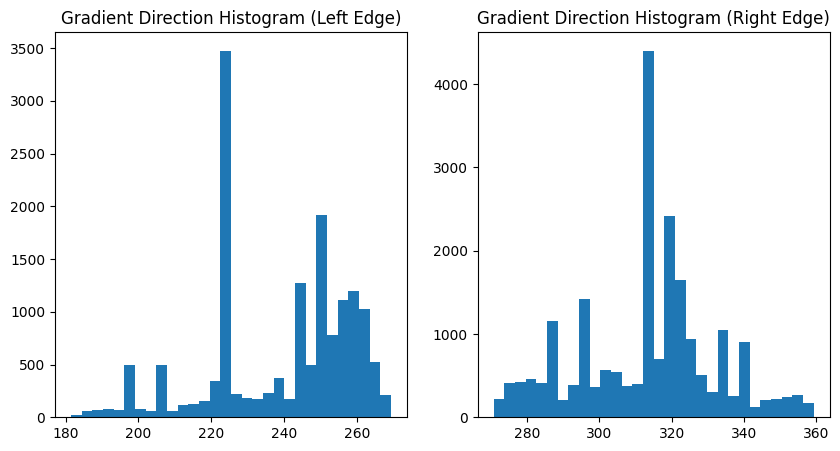

In [61]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Right Edge)');

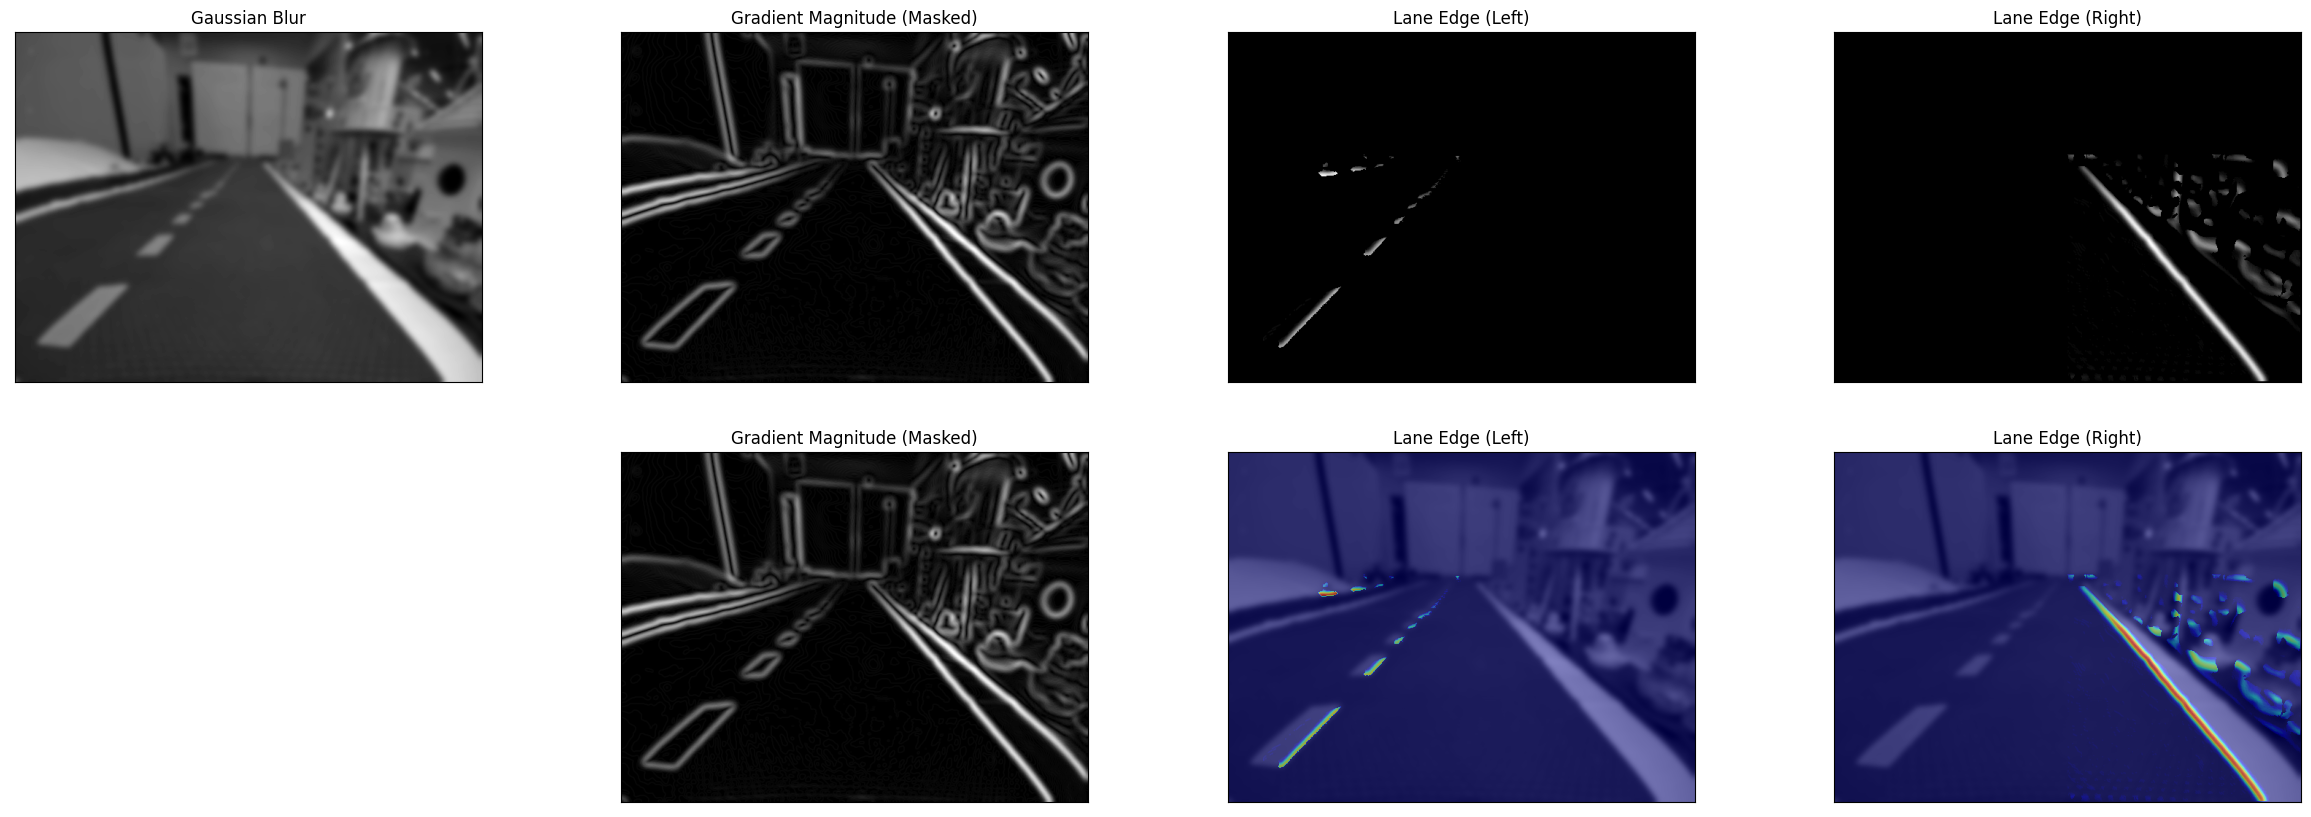

In [62]:
# Let's generate the complete set of masks, including those based on color
mask_left_edge = mask_ground * mask_left * mask_mag * mask_sobelx_neg * mask_sobely_neg * mask_yellow

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

ax6 = fig.add_subplot(2,4,6)
ax6.imshow(mask_mag*Gmag,cmap = 'gray')
ax6.set_title('Gradient Magnitude (Masked)'), ax6.set_xticks([]), ax6.set_yticks([])
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(img_gaussian_filter,cmap = 'gray')
ax7.imshow(Gmag * mask_left_edge, cmap='jet', alpha=0.5)
ax7.set_title('Lane Edge (Left)'), ax7.set_xticks([]), ax7.set_yticks([])
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(img_gaussian_filter,cmap = 'gray')
ax8.imshow(Gmag * mask_right_edge, cmap='jet', alpha=0.5)
ax8.set_title('Lane Edge (Right)'), ax8.set_xticks([]), ax8.set_yticks([]);

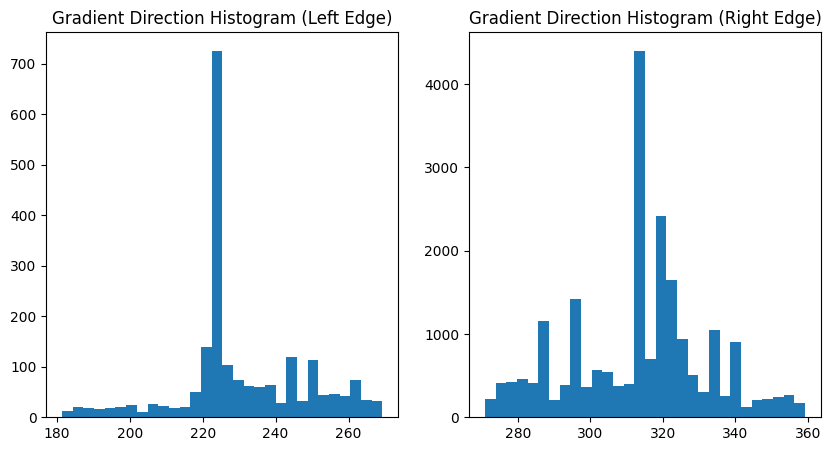

In [63]:
# Now, let's apply the full set of masks to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Right Edge)');